Миллионы людей ежедневно пользуются поиском по картинкам в Яндексе. 
Команда Яндекса прикладывает много усилий чтобы сделать сервис более полезным и удобным. 
Но для этого нужно хорошо понимать, какие задачи решают пользователи. К примеру, есть гипотеза, что интересы людей, ищущих картинки на мобильных устройствах и на десктопных компьютерах, заметно отличаются.
Вам нужно проверить эту гипотезу, сравнив запросы на разных платформах.

В файле data.json лежит выборка запросов к Яндекс Картинкам за несколько недель.
Каждый запрос описан словарем со следующими параметрами:
```
    query - текст запроса
    ts - timestamp запроса
    platform - платформа (touch - мобильный устройства, desktop - компьютеры)
```
Во время интервью Вам будет предложено ответить на ряд вопросов на основе имеющихся данных.

В ходе работы над задачей Вам будет разрешено использовать любые дополнительные материалы, поисковые системы и т.п.

**Примеры вопросов, которые могут быть заданы**
1. Выведите топ-10 самых частотных запросов в каждой платформе (desktop, touch). Какие отличия Вы видите?
2. Посмотрите, чем отличается трафик запросов в течение дня. Как можно объяснить отличие?
3. Выделите тематики запросов, контрастные для мобильных и компьютеров. Являются ли различия статистически значимыми?

In [190]:
import json
import pandas as pd
 
#  Загрузим данные
with open('data.json', 'r') as file:
    data = json.load(file)

df = pd.DataFrame.from_dict(data)

In [191]:
# Выведите топ-10 самых частотных запросов в каждой платформе (desktop, touch).
df.groupby(['platform', 'query']).size().reset_index(name='cnt')\
    .sort_values(['platform','cnt'], ascending=[True, False]).groupby(['platform']).head(10)

,platform,query,cnt
9177,desktop,календарь 2021,2804
20421,desktop,таблица менделеева,2631
9570,desktop,картинки,1647
15790,desktop,порно,1342
3557,desktop,английский алфавит,1293
13694,desktop,обои на рабочий стол,1143
2416,desktop,Одноклассники (социальная сеть),1116
18560,desktop,секс,895
20412,desktop,таблица квадратов,877
3382,desktop,алфавит,874


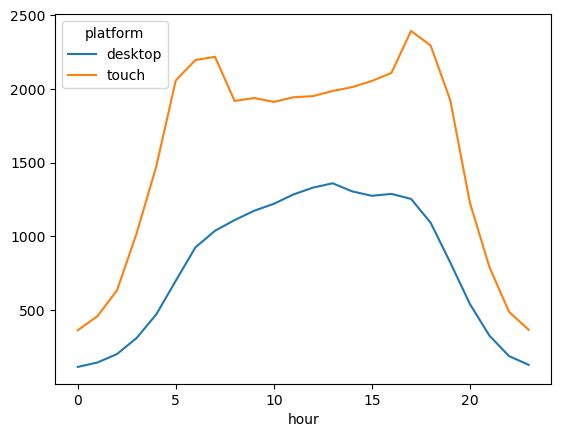

In [192]:
# Преобразование в дату и время
df['ts'] = pd.to_datetime(df.ts, unit='s')
df_plot = df.set_index('ts').groupby([pd.Grouper(freq='1H'), 'platform']).platform.size().unstack()
df['hour'] = df['ts'].dt.hour
df['days'] = df['ts'].dt.day
df['weekend'] = df['ts'].dt.dayofweek.map(lambda x: 1 if x in (6,7) else 0)
(df.groupby(['platform', 'hour']).size()/df.groupby(['platform', 'hour']).days.nunique()).unstack(0).plot();


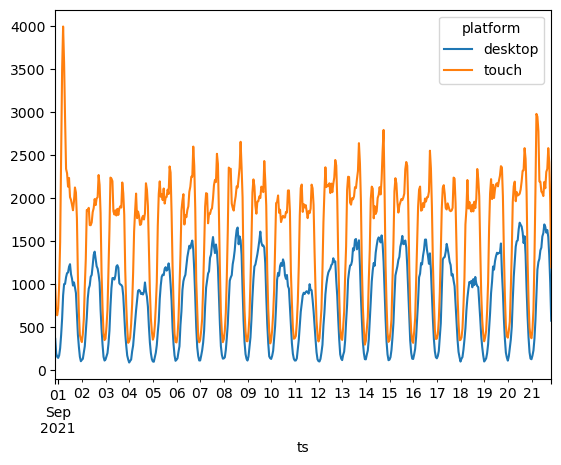

In [193]:
# Проверим количество запросов по часам в разрезе платформ
df_plot.plot();

In [194]:
import nltk
import pymorphy2

stopwords = nltk.corpus.stopwords.words("russian")
lemmatizer = pymorphy2.MorphAnalyzer()

def collect_words(x):
    if len(x)>2: return list(nltk.trigrams(x))
    elif len(x)>1: return list(nltk.bigrams(x))
    else: return [tuple(x)]

# preprocessing queries
df['query'] = df['query'].str.replace(r"тик ток.{1,3}", 'тикток', regex=True)
df['query'] = df['query'].str.replace(r"[^\w\s]", '', regex=True)
df['tokenized_query'] = df['query'].map(lambda x: nltk.word_tokenize(x))
df['tokenized_query'] = df['tokenized_query'].map(lambda x: [word.lower() for word in x if word.lower() not in stopwords])
df['tokenized_query'] = df['tokenized_query'].map(lambda x: [lemmatizer.parse(word)[0].normal_form for word in x])
df['tokenized_wordgrams'] = df.tokenized_query.map(collect_words)

# calculate word_corpus
queries_db_words = df.groupby('platform').tokenized_query.apply(lambda x: [j for i in list(x) for j in i])
queries_db_bigrams = df.explode('tokenized_wordgrams').groupby('platform')['tokenized_wordgrams'].apply(list)
queries_db = pd.concat([queries_db_words, queries_db_bigrams], axis=1)
queries_db

,tokenized_query,tokenized_wordgrams
platform,,
desktop,"[малевич, картина, бактериофаг, кадр, фильм, к...","[(малевич, картина), (бактериофаг,), (кадр, фи..."
touch,"[порно, фото, секс, день, рождение, лена, звер...","[(порно, фото), (секс,), (день, рождение, лена..."


In [195]:
from collections import Counter
import numpy as np

# define top 10 contrast queries
desktop = Counter(queries_db.loc['desktop', 'tokenized_wordgrams'])
touch = Counter(queries_db.loc['touch', 'tokenized_wordgrams'])

contrast_analysis = pd.concat([
                            pd.DataFrame.from_dict(desktop, orient='index', columns=['cnt_desktop']),
                            pd.DataFrame.from_dict(touch, orient='index', columns=['cnt_touch'])
                            ], axis=1)
contrast_analysis = contrast_analysis[contrast_analysis.notna().all(axis=1)]
contrast_analysis['cnt_desktop_share'] = contrast_analysis['cnt_desktop']/contrast_analysis['cnt_desktop'].sum()
contrast_analysis['cnt_touch_share'] = contrast_analysis['cnt_touch']/contrast_analysis['cnt_touch'].sum()
contrast_analysis['delta'] = np.abs(contrast_analysis.cnt_desktop_share-contrast_analysis.cnt_touch_share)
contrast_analysis.sort_values('delta', ascending=False).iloc[:10]

cnt_desktop  cnt_touch  cnt_desktop_share  \
день         рождение   женщина          2124.0    15780.0           0.015867   
                        мужчина          1061.0    10164.0           0.007926   
обои         рабочий    стол             3122.0      220.0           0.023323   
поздравление день       рождение         1192.0     8428.0           0.008905   
открытка     день       рождение          956.0     7407.0           0.007142   
добрый       утро       картинка          251.0     3842.0           0.001875   
рождество    пресвятой  богородица        299.0     3668.0           0.002234   
день         рождение   девушка           182.0     3312.0           0.001360   
одноклассник социальный сеть             1158.0       20.0           0.008651   
календарь    2022       год              1209.0      187.0           0.009032   

                                    cnt_touch_share     delta  
день         рождение   женщина            0.053669  0.037802  
                        мужчина            0.034569  0.026643  
обои         рабочий    стол               0.000748  0.022574  
поздравление день       рождение           0.028665  0.019760  
открытка     день       рождение           0.025192  0.018050  
добрый       утро       картинка           0.013067  0.011192  
рождество    пресвятой  богородица         0.012475  0.010242  
день         рождение   девушка            0.011264  0.009905  
одноклассник социальный сеть               0.000068  0.008583  
календарь    2022       год                0.000636  0.008396

In [196]:
# calculate some essential columns for stats analysis
desktop_sum_queries = contrast_analysis.cnt_desktop.sum()
touch_sum_queries = contrast_analysis.cnt_touch.sum()
total_sum_queries = desktop_sum_queries+touch_sum_queries
data = contrast_analysis.sort_values('delta', ascending=False).iloc[:10, :2]
data['row_sum'] = data.sum(axis=1)
data['cnt_desktop_expected'] = data.row_sum*desktop_sum_queries/total_sum_queries
data['cnt_touch_expected'] = data.row_sum*touch_sum_queries/total_sum_queries

In [197]:
from scipy import stats

# calculate p_value and make conclusion
desktop = ((data.cnt_desktop-data.cnt_desktop_expected)**2/data.cnt_desktop_expected).sum()
touch = ((data.cnt_touch-data.cnt_touch_expected)**2/data.cnt_touch_expected).sum()
chi2_stat = desktop+touch
deg_fr = (len(data[['cnt_desktop', 'cnt_touch']].columns)-1)*len(data)-1
p_val = 1 - stats.chi2.cdf(chi2_stat, deg_fr)

print('Стат. значимо' if p_val<0.01 else 'Не стат. значимо')

Стат. значимо
